@file fakeNews.ipynb
<br>
@author hugomtr
<br>
@brief 
<br>
@version 0.1
<br>
@date 2022-02-28
<br>
@copyright Copyright (c) 2022

# Starting

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 30 08:24:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

import sklearn

# import some classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

# import modules for vectorizing and pipe
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline

# scale data
from sklearn.preprocessing import StandardScaler

# modules for model selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# modules for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

# modules for vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

# others
import itertools
import random

from sklearn.exceptions import ConvergenceWarning

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/FakeNews'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/FakeNews


'/content/gdrive/My Drive/Colab Notebooks/FakeNews'

# Loading a dataset and choose classification


In [ ]:
df = pd.read_csv("claimskg.csv",sep=";")
del df['Unnamed: 0']

def f(x):
  if x==1:
    return 0
  if x==2:
    return 2
  return 1

def g(x):
  if x==1 or x==0:
    return 0
  else: 
    return 1

def choose_classification():
  print("Select which classification you want:")
  print("0 : {True} vs {False}")
  print("1 : {True,False} vs {Mixture}")
  print("2 : {True} vs {False} vs {Mixture}")
  n = int(input("select a number: "))
  return n

def select(n,df):
  if n == 0:
    # {True} vs {False}
    df = df[df.truthRating.isin([0,1])]
  if n == 1:
    df["truthRating"] = df["truthRating"].apply(g)
    df = df[df.truthRating.isin([0,1])]
  return df

In [ ]:
df["truthRating"] = df["truthRating"].apply(f)

n = choose_classification()

df = select(n,df)

classes = df.ratingName.unique()

label_dict = {}
for index, possible_label in enumerate(classes):
    label_dict[possible_label] = index

df['label'] = df.ratingName.replace(label_dict)
df = df[["text","label","ratingName"]]

train, test = train_test_split(df, test_size=0.1, shuffle=True)

Select which classification you want:
0 : {True} vs {False}
1 : {True,False} vs {Mixture}
2 : {True} vs {False} vs {Mixture}
select a number: 1


In [ ]:
train.groupby(['ratingName', 'label']).count()

,,text
ratingName,label,
False,1,9024
MIXTURE,2,8973
True,0,4009


In [ ]:
test.groupby(['ratingName', 'label']).count()

,,text
ratingName,label,
False,1,976
MIXTURE,2,1027
True,0,443


In [ ]:
# Saving Data in 2 csv file
train.to_csv("train.csv",sep=';')
test.to_csv("test.csv",sep=';')

# Ingenierie Textuelle

### Installation Packages & Loading Data

In [ ]:
!pip install langdetect 
!pip install contractions

     |████████████████████████████████| 981 kB 9.7 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=61a6c04e7ba87b3fdb735b7bf3841a56d9238af672b44b535899173deff05330
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 106 kB 8.8 MB/s 
     |████████████████████████████████| 284 kB 55.5 MB/s 


In [ ]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys

import contractions

# librairie BeautifulSoup
from bs4 import BeautifulSoup

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

## detection de language
import langdetect 

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import RegexpParser

# il est possible de charger l'ensemble des librairies en une seule fois 
# décocher le commentaire de la ligne ci-dessous
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
nltk.download('tagsets')
nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
from spacy.tokens import Span
# il faut sélectionner pour quelle langue les traitements vont être faits.
nlp = spacy.load('en')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Loading
df_train = pd.read_csv("train.csv",sep=";")
df_test = pd.read_csv("test.csv",sep=";")

del df_train['Unnamed: 0'];del df_test['Unnamed: 0']

### Text Preprocessing class and function





In [ ]:
# text = np.concatenate((df_train["text"],df_test["text"]))

# def contains_digit(word):
#   for c in word:
#     if c.isdigit():
#       return True
#   return False

# stopwords = np.array(nltk.corpus.stopwords.words('english'))

# for i,sentence in zip(range(len(text)),text):
#   # Removing punctuation
#   tokenizer = nltk.RegexpTokenizer(r"\w+")
#   sentence = tokenizer.tokenize(sentence)

#   sentence = " ".join(sentence)
#   sentence = re.sub(r'Unknown', '', str(sentence))

#   sentence = word_tokenize(sentence)

#   # converting each word to lowercase
#   sentence = [word.lower() for word in sentence if not word in stopwords]

#   # Removing stopwords
#   sentence = [word for word in sentence if not word in stopwords]

#   # Removing word with only one letter
#   sentence = [word for word in sentence if len(word) != 1]

#   # Removing word with digits
#   sentence = [word for word in sentence if not contains_digit(word)]

#   # stemmer words 
#   # lemmatizer = WordNetLemmatizer()
#   ps = PorterStemmer()
#   sentence = [ps.stem(word) for word in sentence]

#   ## Removing pronouns infinitive verbs dt...
#   # for word in nltk.pos_tag(sentence):
#   #   word_to_keep = []
#   #   if word[1] not in ['IN', 'PP', 'DT','PRP$','VB','MD']:
#   #     word_to_keep.append(word[0])
  
#   sentence = (" ").join(sentence)
#   text[i] = sentence

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def MyCleanText(X, 
  lowercase=False, # mettre en minuscule
  removestopwords=False, # supprimer les stopwords
  removedigit=False, # supprimer les nombres 
  getstemmer=False, # conserver la racine des termes
  getlemmatisation=False # lematisation des termes 
  ):

  sentence=str(X)

  # suppression des caractères spéciaux
  sentence = re.sub(r'[^\w\s]',' ', sentence)
  # suppression de tous les caractères uniques
  sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
  # substitution des espaces multiples par un seul espace
  sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)
  # subtitution of Unknown
  sentence = re.sub(r'Unknown', '', sentence)

  # remove some space
  sentence = sentence.strip()

  # decoupage en mots
  tokens = word_tokenize(sentence)
  if lowercase:
    tokens = [token.lower() for token in tokens]

  # suppression ponctuation
  table = str.maketrans('', '', string.punctuation)
  words = [token.translate(table) for token in tokens]

  # suppression des tokens non alphabetique ou numerique
  words = [word for word in words if word.isalnum()]

  # suppression des tokens numerique
  if removedigit:
    words = [word for word in words if not word.isdigit()]

  # suppression des stopwords
  if removestopwords:
    stopwords = np.array(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if not word in stopwords]

  # lemmatisation
  if getlemmatisation:
    lemmatizer=WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word)for word in words]


  # racinisation
  if getstemmer:
    ps = PorterStemmer()
    words=[ps.stem(word) for word in words]

    sentence= ' '.join(words)

  return sentence 

class TextNormalizer(BaseEstimator, TransformerMixin):
  def __init__(self, 
    removestopwords=False, # suppression des stopwords
    lowercase=False,# passage en minuscule
    removedigit=False, # supprimer les nombres 
    getstemmer=False,# racinisation des termes 
    getlemmatisation=False # lemmatisation des termes 
    ):
  
    self.lowercase=lowercase
    self.getstemmer=getstemmer
    self.removestopwords=removestopwords
    self.getlemmatisation=getlemmatisation
    self.removedigit=removedigit
    

  def transform(self, X, **transform_params):
    # Nettoyage du texte
    X=X.copy() # pour conserver le fichier d'origine
    return [MyCleanText(text,lowercase=self.lowercase,
    getstemmer=self.getstemmer,
    removestopwords=self.removestopwords,
    getlemmatisation=self.getlemmatisation,
    removedigit=self.removedigit) for text in X]

  def fit(self, X, y=None, **fit_params):
    return self
  
  def fit_transform(self, X, y=None, **fit_params):
    return self.fit(X).transform(X)

  def get_params(self, deep=True):
    return {
    'lowercase':self.lowercase,
    'getstemmer':self.getstemmer,
    'removestopwords':self.removestopwords,
    'getlemmatisation':self.getlemmatisation,
    'removedigit':self.removedigit
    } 
  
  def set_params (self, **parameters):
    for parameter, value in parameters.items():
      setattr(self,parameter,value)
    return self 



In [ ]:
def preprocess_selection(model_name,model,X,y,lowercase=False):
    CV_brut = Pipeline([('cleaner', TextNormalizer()), 
                        ('count_vectorizer', CountVectorizer(lowercase=False)),
                        (model_name, model)])
    CV_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    CV_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    CV_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=False)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    
    CV_lowStopna = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=True)), 
                        ('count_vectorizer', CountVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    TFIDF_brut = Pipeline ([('cleaner', TextNormalizer()), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    TFIDF_lowcase = Pipeline([('cleaner', TextNormalizer(removestopwords=False,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    TFIDF_lowStop = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=False,removedigit=False)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    TFIDF_lowStopstem = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=False)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])
    TFIDF_lowStopna = Pipeline([('cleaner', TextNormalizer(removestopwords=True,lowercase=True,
                                                getstemmer=True,removedigit=True)), 
                        ('tfidf_vectorizer', TfidfVectorizer(lowercase=lowercase)),
                        (model_name, model)])

    all_models = [
        ("CV_brut", CV_brut),
        ("CV_lowcase", CV_lowcase),
        ("CV_lowStop", CV_lowStop),
        ("CV_lowStopstem",CV_lowStopstem),
        ("CV_lowStopna",CV_lowStopna),
        ("TFIDF_lowStopna", TFIDF_lowStopna),
        ("TFIDF_lowcase", TFIDF_lowcase),
        ("TFIDF_lowStop", TFIDF_lowStop),
        ("TFIDF_lowStopstem",TFIDF_lowStopstem),
        ("TFIDF_brut", TFIDF_brut),
    ]

    print ("Evaluation des différentes configurations : ")
    unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
    scores = sorted(unsorted_scores, key=lambda x: -x[1])


    print(tabulate(scores, floatfmt='.4f', headers=('Pipeline', 'Score')))

### Selecting best preprocessing
OPTIONAL!
WARNING !!!
<br>
May take some minutes
<br>
example below ->

In [ ]:
X = df_train["text"]
y = df_train["label"] 

X_s = X.sample(500)
y_s = y.loc[X_s.index]
preprocess_selection("logistic_regression",LogisticRegression(),X_s,y_s)

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
TFIDF_lowStopna     0.5360
TFIDF_lowStopstem   0.5320
CV_brut             0.5160
CV_lowcase          0.5160
CV_lowStop          0.5160
TFIDF_lowcase       0.5100
TFIDF_lowStop       0.5100
TFIDF_brut          0.5100
CV_lowStopstem      0.5080
CV_lowStopna        0.5020


# Classifieur Binaires

In [ ]:
def plot_confusion_matrix(cm, classes=classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = 2*cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_quad_error(X,y,model):
  arr1=[];arr2=[]
  size = np.linspace(500,int(len(X)),25).astype('int32')
  for m in size:
    X_s = X.sample(m)
    y_s = y.loc[X_s.index]
    X_train,X_val,y_train,y_val = train_test_split(X_s,y_s,train_size=0.8,random_state=0)
    clf = model.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    squarred_error_train = (1/len(y_pred_train))*np.sum((y_pred_train - y_train)**2)
    squared_error_CV = (1/len(y_pred_val))*np.sum((y_pred_val - y_val)**2)
    arr1.append(squarred_error_train)
    arr2.append(squared_error_CV)

  plt.plot(size,arr1,label='train error')
  plt.plot(size,arr2,label='cv error')
  plt.xlabel("Training Size")
  plt.gca().set_xlim([100,len(X)])
  plt.ylabel("Quadratic Error")
  plt.title("Model Evaluation")
  plt.legend()
  plt.show()

## Logistic Regression

### special preprocessing based on frequency transformation

Before running the classifier we need to compute the fake frequency and non fake frequency of each word. By this I mean counting each word appareance in the fake corpus (set of all fake post) and in the non fake corpus (set of all non fake post. From approximatively 3000 features one corresponding to each word we are now only dealing with 2.

In [ ]:
# Last step of preprocessing = vectorizing the text
text = np.concatenate((df_train["text"],df_test["text"]))

text_normalizer=TextNormalizer(lowercase=True)  
text=text_normalizer.fit_transform(text)
print("texte après application des pré-traitements")
text = np.array(text)   

dfbis_train = df_train.copy() 
dfbis_train["text"] = text[:len(df_train)]

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(text)
corpus = np.array(vectorizer.get_feature_names())

texte après application des pré-traitements


In [ ]:
def get_fake_no_fake_text(text):
  idx0 = np.array(df_train[df_train["truthRating"] == 0].index)
  idx1 = np.array(df_train[df_train["truthRating"] == 1].index)
  fake_text = text[idx0]
  non_fake_text = text[idx1]
  return fake_text,non_fake_text


def compute_frequency(fake_text,non_fake_text):
  # Computes 2 different frequency use of dictionary for O(1) time acces to value of a paticular word
  fake_text = " ".join(fake_text)
  fake_text = word_tokenize(fake_text)
  non_fake_text = " ".join(non_fake_text)
  non_fake_text = word_tokenize(non_fake_text)
  corpus = np.unique(np.concatenate((fake_text,non_fake_text),axis=0))

  FakeFreq = {w:0 for w in corpus}
  NonFakeFreq = {w:0 for w in corpus}

  for word in fake_text:
    FakeFreq[word] += 1

  for word in non_fake_text:
    NonFakeFreq[word] += 1

  return FakeFreq,NonFakeFreq


Before running the logistic regression algorithm we need to compute the frequency of each word in the 2 corpus
<br>

The training example will the have the following format with 1 for the bias term. 
$$ X^{(i)} = \begin{pmatrix}
1 \\
X_{Fake}^{(i)} \\
X_{NoFake}^{(i)} 
\end{pmatrix} $$


In [ ]:
fake_text,non_fake_text= get_fake_no_fake_text(text)
FakeFreq,NonFakeFreq = compute_frequency(fake_text,non_fake_text)

In [ ]:
def feat_extraction_fake(row):
  row_text = word_tokenize(row)
  sum_fake_freq = 0
  for word in row_text:
    sum_fake_freq += FakeFreq[word]
  return sum_fake_freq


def feat_extraction_no_fake(row):
  row_text = word_tokenize(row)
  sum_non_fake_freq = 0
  for word in row_text:
    sum_non_fake_freq += NonFakeFreq[word]
  return sum_non_fake_freq

In [ ]:
dfbis_train["bias"] = 1
dfbis_train["fake"] = dfbis_train["text"].apply(feat_extraction_fake)
dfbis_train["no fake"] = dfbis_train["text"].apply(feat_extraction_no_fake)

df_X_train = dfbis_train[["fake","no fake"]]

Logistic Regression implementation:
<br>
In short we are the trying to minimize the following cost function with the help to the famous gradient descent algorithm.
<br>
$$ J(θ) = -\dfrac{1}{m}*\sum_{i=1}^{m}[ \log h(x^{(i)},θ) + (1 - y^{(i)})*log(1 - h(x^{(i)},θ))] $$
<br>
with h the sigmoid function define as follow $$ h(x^{i},θ) = \dfrac{1}{1 + e^{-θ^{T}*x^{(i)}}} $$

<br>

$m =$ number of training examples
<br>

$x(i) =$ i-th example of the training set 
<br>

Thus we make sure to resolve a convex problem and by this gradient descent find a global minima.

### Training

In [ ]:
X,y = df_X_train,dfbis_train["ratingName"] 

X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.8,random_state=0)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_val)

target_names = ["No Fake","Fake"]

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred, target_names=target_names))

accuracy 0.6228932584269663
              precision    recall  f1-score   support

     No Fake       0.61      0.64      0.63       695
        Fake       0.64      0.60      0.62       729

    accuracy                           0.62      1424
   macro avg       0.62      0.62      0.62      1424
weighted avg       0.62      0.62      0.62      1424



Confusion matrix, without normalization


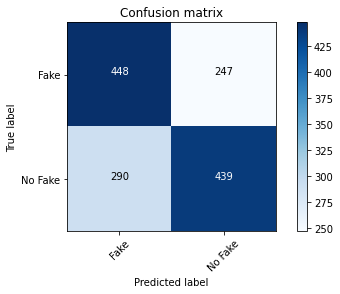

In [ ]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), classes=["Fake","No Fake"])

Analyze if there is overfitting or underfitting

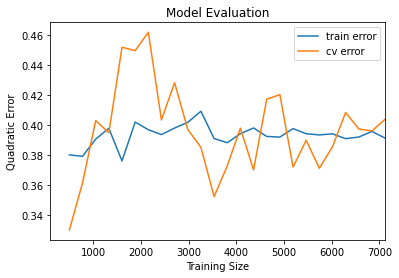

In [ ]:
plot_quad_error(X,y,LogisticRegression())

Etant donnée la simplicité de nos features seulement 2 il n'est pas nécesaire ici d'appliquer des algorithmes de classifications plus performant sachant qu'ici une simple regression répond très bien à notre problème.

## Naives Bayes

<br>

Naives Bayes Approach Inference Rules for binary classification.
<br>

$$\prod_{i=1}^{n} \dfrac{P \left( wi \middle| \ Fake \right)}{P \left( wi \middle| \ NonFake \right)}$$
<br>
This expression says that we're going to take the product across all of the words (n words) in a post of the probability for each word in the fake class divide it by the probability in the non fake class
<br>

Laplacian Smoothing technique to avoid zero probability issue with the formula above
<br>

$$P \left( wi \middle| \ class \right) = \dfrac{freq(wi,class)+1}{Nc + Vc} \\ class \in \{ Fake , Non Fake \} $$
<br>

$N_c = \ $frequency of all words in class 
class
<br>

​$V =\ $number of unique words in vocabulary
<br>

In [ ]:
X = df_train["text"]
y = df_train["ratingName"] 

text_normalizer= TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=True) 
X=text_normalizer.fit_transform(X)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.7,random_state=0)

nb = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred,target_names=classes))

accuracy 0.5031900138696255
              precision    recall  f1-score   support

        True       0.55      0.49      0.52      1197
       False       0.46      0.35      0.40      1165
     Mixture       0.50      0.67      0.57      1243

    accuracy                           0.50      3605
   macro avg       0.50      0.50      0.49      3605
weighted avg       0.50      0.50      0.50      3605



## Comparaison de tous les classifieurs

In [ ]:
X = df_train["text"]
y = df_train["ratingName"]

## Cross Validation

In [ ]:
# found when testing different parameters in the preprocessing  
text_normalizer= TextNormalizer(removestopwords=False,lowercase=True,getstemmer=False,removedigit=False) 
X=text_normalizer.fit_transform(X)

models = []
models.append(('LRregression', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('MultinomialNB', MultinomialNB()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('SGDClassifier',SGDClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('PassiveAggressiveClassifier',PassiveAggressiveClassifier()))

In [ ]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=5, shuffle=True)
  model = make_pipeline(TfidfVectorizer(), model)
  cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LRregression: 0.501873 (0.008773)
KNN: 0.456097 (0.011841)
MultinomialNB: 0.510445 (0.010277)
DecisionTreeClassifier: 0.405077 (0.013968)
SVM: 0.512276 (0.015597)
SGDClassifier: 0.500707 (0.008558)
RandomForest: 0.497295 (0.009302)
PassiveAggressiveClassifier: 0.443362 (0.006525)


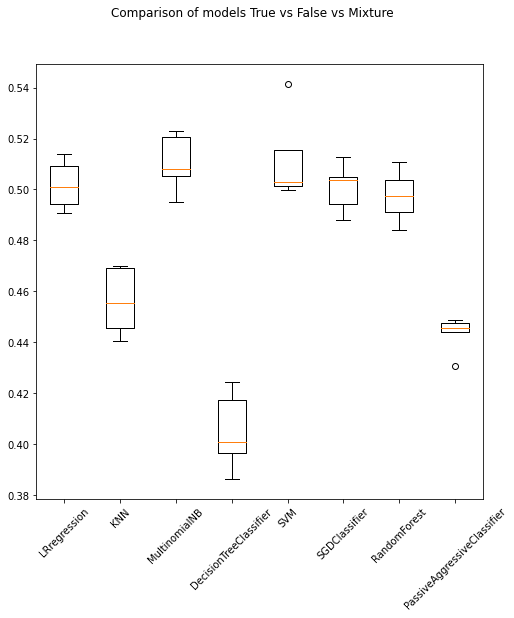

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.suptitle('Comparison of models {} vs {} vs {}'.format(classes[0],classes[1],classes[2]))
ax = fig.add_subplot(111)
ax.boxplot(results)
ax.set_xticklabels(names,rotation = 45)
plt.show()

## Grid Search CV affinement des meilleurs paramètres

### Logistic Regression

In [ ]:
X = df_train["text"]
y = df_train["truthRating"] 

X_s = X.sample(1000)
y_s = y.loc[X_s.index]
preprocess_selection("logistic_regression",LogisticRegression(),X_s,y_s)

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
TFIDF_lowcase       0.4910
TFIDF_lowStop       0.4910
TFIDF_brut          0.4910
CV_brut             0.4770
CV_lowcase          0.4770
CV_lowStop          0.4770
TFIDF_lowStopna     0.4670
TFIDF_lowStopstem   0.4660
CV_lowStopstem      0.4440
CV_lowStopna        0.4420


In [ ]:
# X = df_train["text"]
# y = df_train["truthRating"]

# # put text normalizer in the pipe is a bad idea because of the very long time processing
# text_normalizer = TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False)
# X = text_normalizer.fit_transform(X)

X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.8,random_state=0)

pipe = Pipeline([('vect', TfidfVectorizer()),
               ('clf', LogisticRegression(solver='lbfgs')),
               ])

grid = {"clf__C":np.logspace(-2,2,4),
        "clf__max_iter":[100,1000]}

gd_srLR = GridSearchCV(pipe,  
                     param_grid=grid,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1,
                    return_train_score=True)

gd_srLR.fit(X_train, y_train)
print('meilleur score ',
 gd_srLR.best_score_,'\n')
print('meilleurs paramètres',
 gd_srLR.best_params_,'\n')
print('meilleur estimateur',
gd_srLR.best_estimator_,'\n')

meilleur score  0.5020790550664691 

meilleurs paramètres {'clf__C': 0.21544346900318834, 'clf__max_iter': 100, 'vect__max_features': None} 

meilleur estimateur Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(C=0.21544346900318834))]) 




 accuracy:  0.5118601747815231 


               precision    recall  f1-score   support

        True       0.53      0.58      0.55       796
       False       0.47      0.40      0.43       769
     Mixture       0.53      0.55      0.54       838

    accuracy                           0.51      2403
   macro avg       0.51      0.51      0.51      2403
weighted avg       0.51      0.51      0.51      2403

Confusion matrix, without normalization


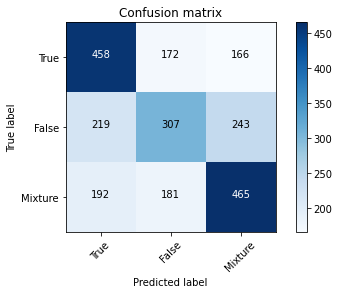

In [ ]:
# Creation d'une instance de l'algorithme en utilisant les meilleurs paramètres
lr = gd_srLR.best_estimator_

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print('\n accuracy: ', accuracy_score(y_pred, y_val),'\n')

print('\n',classification_report(y_val, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_val, y_pred))

Overfitting, Underfitting ?

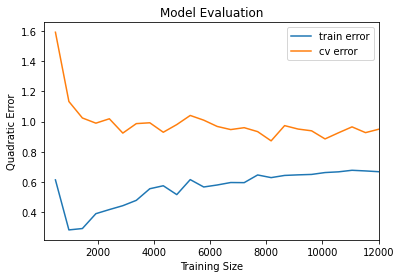

In [ ]:
X = df_train["text"]
y = df_train["truthRating"]
text_normalizer = TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False)
X = text_normalizer.fit_transform(X)
X = pd.Series(X)
plot_quad_error(X,y,lr)

Evaluation sur le test set


 accuracy:  0.48239700374531835 


               precision    recall  f1-score   support

        True       0.48      0.67      0.56       448
       False       0.47      0.40      0.43       454
     Mixture       0.50      0.38      0.43       433

    accuracy                           0.48      1335
   macro avg       0.48      0.48      0.47      1335
weighted avg       0.48      0.48      0.47      1335

Confusion matrix, without normalization


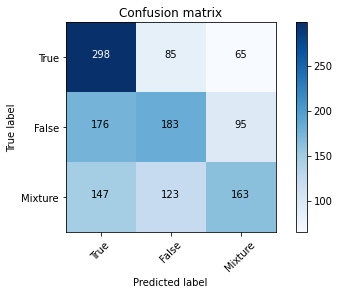

In [ ]:
X_test,y_test = df_test["text"],df_test["truthRating"]
y_pred = lr.predict(X_test)
print('\n accuracy: ', accuracy_score(y_pred, y_test),'\n')

print('\n',classification_report(y_test, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### SVC

In [ ]:
X = df_train["text"]
y = df_train["truthRating"] 

X_s = X.sample(1000)
y_s = y.loc[X_s.index]
preprocess_selection("SVC",SVC(),X_s,y_s)

Evaluation des différentes configurations : 
Pipeline             Score
-----------------  -------
CV_lowStopstem      0.6480
CV_lowStopna        0.6430
TFIDF_lowStopna     0.6400
TFIDF_lowStopstem   0.6400
TFIDF_lowcase       0.6320
TFIDF_lowStop       0.6320
TFIDF_brut          0.6320
CV_brut             0.6180
CV_lowcase          0.6180
CV_lowStop          0.6180


In [ ]:
X = df_train["text"]
y = df_train["truthRating"]
# put text normalizer in the pipe is a bad idea because of the very long time processing
text_normalizer = TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False)
X = text_normalizer.fit_transform(X)
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.8,random_state=0)

pipe = Pipeline([('vect', TfidfVectorizer()),
               ('clf', SVC()),
              ])

grid = {'clf__C': [100, 1000], 
        'clf__kernel': ['linear'],
        'clf__gamma': [0.001, 0.0001,0.00001], 
        'clf__kernel': ['rbf']}

gd_srSVC = GridSearchCV(pipe,  
                     param_grid=grid,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1,
                    return_train_score=True)

gd_srSVC.fit(X_train, y_train)
print('meilleur score ',
 gd_srSVC.best_score_,'\n')
print('meilleurs paramètres',
 gd_srSVC.best_params_,'\n')
print('meilleur estimateur',
gd_srSVC.best_estimator_,'\n')

meilleur score  0.6670833333333333 

meilleurs paramètres {'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'} 

meilleur estimateur Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', SVC(C=1000, gamma=0.0001))]) 




 accuracy:  0.6652777777777777 


               precision    recall  f1-score   support

  True,False       0.66      0.66      0.66      1768
     Mixture       0.67      0.67      0.67      1832

    accuracy                           0.67      3600
   macro avg       0.67      0.67      0.67      3600
weighted avg       0.67      0.67      0.67      3600

Confusion matrix, without normalization


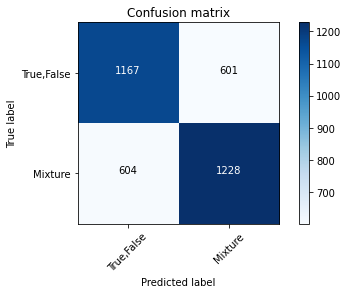

In [ ]:
# Creation d'une instance de l'algorithme en utilisant les meilleurs paramètres
lr = gd_srSVC.best_estimator_

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print('\n accuracy: ', accuracy_score(y_pred, y_val),'\n')

print('\n',classification_report(y_val, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_val, y_pred))

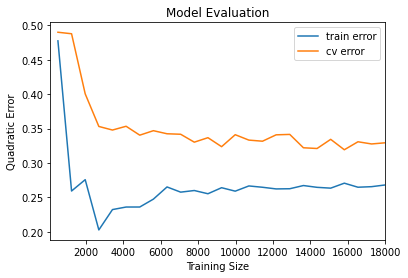

In [ ]:
X = df_train["text"]
y = df_train["truthRating"]
text_normalizer = TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False)
X = text_normalizer.fit_transform(X)
X = pd.Series(X)
plot_quad_error(X,y,lr)

Evaluation sur le test Set


 accuracy:  0.648 


               precision    recall  f1-score   support

  True,False       0.62      0.76      0.68      1008
     Mixture       0.69      0.54      0.60       992

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.65      0.65      0.64      2000

Confusion matrix, without normalization


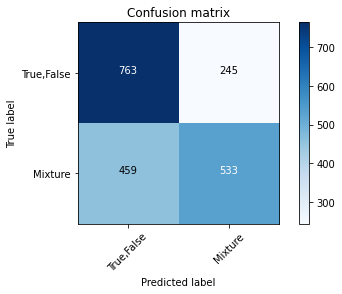

In [ ]:
X_test,y_test = df_test["text"],df_test["truthRating"]
y_pred = lr.predict(X_test)
print('\n accuracy: ', accuracy_score(y_pred, y_test),'\n')

print('\n',classification_report(y_test, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### MultinomialNB

### RandomForest

In [ ]:
X = df_train["text"]
y = df_train["truthRating"]
text_normalizer= TextNormalizer(removestopwords=False,lowercase=True,getstemmer=False,removedigit=False) 
X=text_normalizer.fit_transform(X)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.7,random_state=0)

pipe = Pipeline([('vect', TfidfVectorizer()),
               ('clf', RandomForestClassifier()),
              ])
grid = { 
    'clf__n_estimators': [100,200],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__max_depth' : [7,8],
    'clf__criterion' :['gini', 'entropy']
}
gd_srLR = GridSearchCV(pipe,  
                     param_grid=grid,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1,
                    return_train_score=True)

gd_srLR.fit(X_train, y_train)
print ('meilleur score ',
 gd_srLR.best_score_,'\n')
print ('meilleurs paramètres',
 gd_srLR.best_params_,'\n')
print ('meilleur estimateur',
gd_srLR.best_estimator_,'\n')

meilleur score  0.5807154703775113 

meilleurs paramètres {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__max_features': 'sqrt', 'clf__n_estimators': 100} 

meilleur estimateur Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt'))]) 




 accuracy:  0.5691489361702128 


               precision    recall  f1-score   support

  True,False       0.55      0.98      0.71      2694
     Mixture       0.82      0.10      0.19      2382

    accuracy                           0.57      5076
   macro avg       0.69      0.54      0.45      5076
weighted avg       0.68      0.57      0.46      5076

Confusion matrix, without normalization


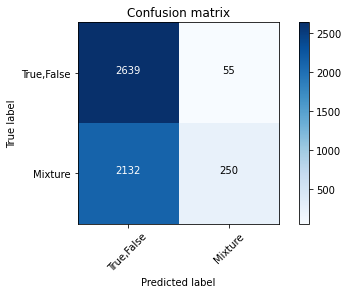

In [ ]:
# Creation d'une instance de l'algorithme en utilisant les meilleurs paramètres
lr = gd_srLR.best_estimator_

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print('\n accuracy: ', accuracy_score(y_pred, y_val),'\n')

print('\n',classification_report(y_val, y_pred,target_names=classes))
plot_confusion_matrix(confusion_matrix(y_val, y_pred),classes = classes)

# Deep learning Approach

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
!pip install tensorflow-text
import tensorflow_text as text

     |████████████████████████████████| 4.9 MB 7.8 MB/s 
     |████████████████████████████████| 462 kB 76.6 MB/s 


In [ ]:
X = df_train["text"]
y = df_train["truthRating"]

# known to perform best with the following parameters 
# given some article on the web
text_normalizer= TextNormalizer(removestopwords=True,lowercase=True,getstemmer=True,removedigit=False) 
X=text_normalizer.fit_transform(X)
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.8,random_state=0)

embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

# Convert each series of words to a word2vec embedding
indiv = []
for i in X_train:
  temp = np.array(embed(i.split(" ")))
  indiv.append(temp)

#Accounts for different length of words
indiv = tf.keras.preprocessing.sequence.pad_sequences(indiv,dtype='float')
indiv.shape

(9612, 60, 250)

In [ ]:
# Convert each series of words to a word2vec embedding
val = []
for i in X_val:
  temp = np.array(embed(i.split(" ")))
  val.append(temp)

val = tf.keras.preprocessing.sequence.pad_sequences(val,dtype='float')

In [ ]:
val.shape

(2403, 52, 250)

In [ ]:
#Sequential model has a 60 cell LSTM layer before Dense layers
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(20,activation='relu'))
model.add(tf.keras.layers.Dense(5,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),\
              loss="binary_crossentropy", metrics=['accuracy'])

#Train model on 10 epochs
model.fit(indiv, y_train,validation_data=[val,y_val],epochs=10)

Epoch 1/10
301/301 [==============================] - 12s 15ms/step - loss: 0.2904 - accuracy: 0.3369 - val_loss: -0.0409 - val_accuracy: 0.3200
Epoch 2/10
301/301 [==============================] - 3s 10ms/step - loss: 0.0109 - accuracy: 0.3357 - val_loss: -0.1098 - val_accuracy: 0.3200
Epoch 3/10
301/301 [==============================] - 3s 10ms/step - loss: -0.1448 - accuracy: 0.3357 - val_loss: -0.4165 - val_accuracy: 0.3200
Epoch 4/10
301/301 [==============================] - 3s 8ms/step - loss: -0.5185 - accuracy: 0.3354 - val_loss: -0.9070 - val_accuracy: 0.3175
Epoch 5/10
301/301 [==============================] - 2s 8ms/step - loss: -1.0473 - accuracy: 0.3359 - val_loss: -1.5920 - val_accuracy: 0.3159
Epoch 6/10
301/301 [==============================] - 2s 6ms/step - loss: -1.7224 - accuracy: 0.3349 - val_loss: -2.3975 - val_accuracy: 0.3200
Epoch 7/10
301/301 [==============================] - 2s 6ms/step - loss: -2.5149 - accuracy: 0.3357 - val_loss: -3.2491 - val_accurac

### Fine tuning BERT

In [ ]:
X = df_train["text"].values
y = df_train["truthRating"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

#Use the bert preprocesser and bert encoder from tensorflow_hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
# Input Layers
input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='news')

# BERT layers
processed = bert_preprocess(input_layer)
output = bert_encoder(processed)

# Fully Connected Layers
# layer = tf.keras.layers.Dropout(0.2, name='dropout')(output['pooled_output'])
layer = tf.keras.layers.Dense(20,activation='relu', name='hidden1')(output['pooled_output'])
layer = tf.keras.layers.Dense(5,activation='relu', name='hidden2')(layer)
layer = tf.keras.layers.Dense(1,activation='sigmoid', name='output')(layer)

model = tf.keras.Model(inputs=[input_layer],outputs=[layer])

In [ ]:
#Compile model on adam optimizer, binary_crossentropy loss, and accuracy metrics
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#Train model on 10 epochs

model.fit(X_train, y_train,epochs=10)

#Evaluate model on test data
model.evaluate(X_val,y_val)

Epoch 1/10
301/301 [==============================] - 72s 207ms/step - loss: -4.7084 - accuracy: 0.3388
Epoch 2/10
301/301 [==============================] - 62s 207ms/step - loss: -46.5022 - accuracy: 0.3433
Epoch 3/10
301/301 [==============================] - 62s 207ms/step - loss: -175.2220 - accuracy: 0.3468
Epoch 4/10
301/301 [==============================] - 62s 207ms/step - loss: -424.6622 - accuracy: 0.3468
Epoch 5/10
301/301 [==============================] - 62s 207ms/step - loss: -821.2997 - accuracy: 0.3486
Epoch 6/10
301/301 [==============================] - 62s 207ms/step - loss: -1389.6600 - accuracy: 0.3458
Epoch 7/10
301/301 [==============================] - 62s 207ms/step - loss: -2120.2373 - accuracy: 0.3485
Epoch 8/10
301/301 [==============================] - 62s 207ms/step - loss: -3051.1926 - accuracy: 0.3475
Epoch 9/10
301/301 [==============================] - 62s 207ms/step - loss: -4168.2231 - accuracy: 0.3489
Epoch 10/10
76/76 [==========================

[-6967.1083984375, 0.332917183637619]

In [ ]:
model.evaluate(X_val,y_val)

76/76 [==============================] - 16s 205ms/step - loss: -6967.1084 - accuracy: 0.3329


[-6967.1083984375, 0.332917183637619]